rewrite a ann_text which return dep_list I can direct put into graph

In [1]:
import spacy
import neuralcoref
from spacy import displacy # https://spacy.io/usage/visualizers
def show_depparse(text):
    doc = nlp(text)
    displacy.render(doc, style='dep',jupyter=True)

nlp = spacy.load("en")

### remove_pronoun

In [2]:
def remove_pronoun(input_t): # replace pronoun with original noun
    neuralcoref.add_to_pipe(nlp)
    doc = nlp(input_t)
    cvt_dict = dict()
    for s in doc._.coref_clusters: # find pronouns save it as dict
        cvt_dict[str(s.main)] = [str(i) for i in s.mentions if i != s.main]
#    print("pronoun dict:", cvt_dict)
    nlp.remove_pipe("neuralcoref")
    
    pn_list = [] # save list as (pronoun, origin noun)
    for pn_main in cvt_dict:
        for pn in cvt_dict[pn_main]:
            pn_list.append( (pn, pn_main) )
    rm_dup_pronouns(pn_list)
#    print("pronoun list without dup:", pn_list)
    
    no_pronoun_t = [] # replace pronoun with origin noun
    for tok in doc:
        if tok.lemma_ == "-PRON-":
            replace_pronoun = False
            for pn_idx, pn in enumerate(pn_list):
                if tok.text == pn[0]:
                    replace_pronoun = True
                    no_pronoun_t.append(pn[1])
                    del(pn_list[pn_idx])
            if pn_list is None or replace_pronoun is False:
                no_pronoun_t.append(tok.text)
        else:
            no_pronoun_t.append(tok.text)
    new_t = " ".join(no_pronoun_t)

    return new_t

def rm_dup_pronouns(pn_list):
    rm_idx_list = []
    for idx, i in enumerate(pn_list):
        if i[0] == i[1]:
            rm_idx_list.append(idx)
    rm_idx_list.reverse()
    for rm_idx in rm_idx_list:
        del pn_list[rm_idx]
    # # example
    # pn_list = [('his', 'Lo Shang-hua (羅尚樺)'),("it","it"), ("the","the"), ('he', 'Lo Shang-hua (羅尚樺)'), ('Lo', 'Lo Shang-hua (羅尚樺)'), ('his aircraft', 'his aircraft'), ('his', 'Pan’s'), ('He', 'Pan’s'), ('his', 'Pan’s'), ('it', 'The Taitung District Prosecutors’ Office'), ('its', 'The Taitung District Prosecutors’ Office')]
    # rm_dup_pronouns(pn_list)
    # pn_list
    
t = 'Angela lives in Boston. She is quite happy in that city. She enjoy her life.'
#t = "He is nice."
remove_pronoun(t)

'Angela lives in Boston . Angela is quite happy in that city . Angela enjoy Angela life .'

### dep_create

#### dep relation format

In [3]:
def ann_text(text):
    no_pronoun_text = remove_pronoun(text)
    doc = nlp(no_pronoun_text)
    
    dep_list = []
    for sent_idx, sent in enumerate(doc.sents):
        for tok_idx, tok in enumerate(sent):
            dep = find_dep(tok)
            if dep is not None:
                dep_list.extend( dep )
#         print("===== next semt =====")
    return dep_list

def dep_fwfw(tok, dp1, dp2, double_dir=False, reverse=False): # dep_forward_forward
    # A->B->C  => C->A
    #     ex: table for food
    #         dep = (table-->for), (for-->food)
    #             => table<--food
    source = None
    target = None
    for child in tok.children:
        if child.dep_ == dp1:
            for cchild in child.children:
                if cchild.dep_ == dp2:
                    source = tok
                    target = cchild
    return creat_dep(source, target, double_dir, reverse)

def dep_side(tok, dp1, dp2, double_dir=False, reverse=False):
    # A<-B->C => C->A
    #     ex: He is nice.   dep = (is->he), (is->nice) 
    #                           => nice->he
    source = None
    target = None
    for child in tok.children:
        if child.dep_ == dp1:
            target = child
        if child.dep_ == dp2:
            source = child
    return creat_dep(source, target, double_dir, reverse)

# def dep_chg(tok, dp, double_dir=False, reverse=True): # dep_change
#     # A->B => B->A
#     #     ex: poor cat     dep = (cat->poor)
#     #                          => poor->cat
#     source = None
#     target = None
#     for child in tok.children:
#         if child.dep_ == dp:
#             source = child
#             target = tok
#     return creat_dep(source, target, double_dir, reverse)

def dep_rem(tok, dp, double_dir=False, reverse=False): # dep_remain
    # A->B => A->B
    #     ex: find->it     dep = (find->it)
    #                          => find->it
    source = None
    target = None
    for child in tok.children:
        if child.dep_ == dp:
            source = tok
            target = child
    return creat_dep(source, target, double_dir, reverse)
    
    
def creat_dep(source, target, double_dir=False, reverse=False):
    if source is not None and target is not None:
        if double_dir:
            return [( tok2node(source), tok2node(target) ), 
                    ( tok2node(target), tok2node(source) )]
        else:
            if reverse: # source -> target
                return (tok2node(target), tok2node(source) )
            else:
                return (tok2node(source), tok2node(target) )
    else:
        return None
def tok2node(token): # token => str( lemma=pos )
    tok_lemma = token.lemma_
    if token.lemma_ == "-PRON-":
        tok_lemma = token.text.lower()
    if token.pos_ == "PUNCT":
        return token.text
    else:
        return "".join([tok_lemma, '=', token.pos_])


#### creat dep

In [4]:
def find_dep(tok):
    tmp_dep_list = []
    tmp_dep_list.append( nsubj(tok) )
    tmp_dep_list.append( nsubjp(tok))
    tmp_dep_list.append( same(tok)  )
    tmp_dep_list.append( ppobj(tok) )
    tmp_dep_list.append( agpbj(tok) )
    tmp_dep_list.append( dative(tok))
    tmp_dep_list.append( ppcomp(tok))
    tmp_dep_list.append( advcl(tok) )
    tmp_dep_list.append(npadvmod(tok))
    tmp_dep_list.append( amod(tok)  )
    tmp_dep_list.append( advmod(tok))
    tmp_dep_list.append( dobj(tok)  )
    tmp_dep_list.append( nummod(tok))
    tmp_dep_list.append( xcomp(tok) )
    tmp_dep_list.append( ccomp(tok) )
    tmp_dep_list.append( acl(tok)   )
    tmp_dep_list.append( poss(tok)  )
    tmp_dep_list.append( relcl(tok) )
    tmp_dep_list.append( oprd(tok)  )
    tmp_dep_list.append(compound(tok))
    return flat_rmNone_list(tmp_dep_list)

def flat_rmNone_list(tmp_dep_list):
    dep_list = []
    for dep in tmp_dep_list:
        if dep is None:
            continue
        elif type(dep) is list:
            dep_list.extend(dep)
        else:
            dep_list.append(dep)
    return dep_list

def nsubj(tok):
    dep = dep_side(tok, 'nsubj', 'acomp') # "I am nice"
    if dep is None:
        dep = dep_side(tok, 'nsubj', 'attr', double_dir=True)  #"Tom is man"
    if dep is None:
        dep = dep_rem(tok, 'nsubj') # "I ran home"
    return dep
def nsubjp(tok):
    return dep_rem(tok, 'nsubjpass') # "dog was found"
def same(tok):
    return dep_rem(tok, 'appos', double_dir=True) # "Sam, the VIP"
def agpbj(tok): # agent+pobj
    return dep_fwfw(tok, 'agent', 'pobj') # "taken by us"
def ppobj(tok): # prep+pobj
    if tok.pos_ in ['NOUN', 'PROPN']: 
        return dep_fwfw(tok, 'prep', 'pobj', reverse=True) # "table of picnic"
    else:                             
        return dep_fwfw(tok, 'prep', 'pobj') # "some of toys"
def dative(tok):
    return dep_rem(tok, 'dative') # "gave me book"
def ppcomp(tok):
    return dep_fwfw(tok, 'prep', 'pcomp') # "play at flying"
def advcl(tok):
    return dep_rem(tok, 'advcl') #"cry when fail"
def npadvmod(tok):
    return dep_rem(tok, 'npadvmod', reverse=False) # "done this morning"
def amod(tok):
    return dep_rem(tok, 'amod', reverse=True) # "poor student"
def advmod(tok):
    return dep_rem(tok, 'advmod', reverse=True) # "less often"
def dobj(tok):
    return dep_rem(tok, 'dobj') # "find it"
def nummod(tok):
    return dep_rem(tok, 'nummod', reverse=True) # "ten books"
def xcomp(tok):
    return dep_rem(tok, "xcomp") # "easy to play"
def ccomp(tok):
    return dep_rem(tok, "ccomp") # "I conside him fool"
def poss(tok):
    return dep_rem(tok, "poss", reverse=True) # "his gun"
def relcl(tok):
    return dep_rem(tok, "relcl", reverse=True) # "girl who likes me"
def oprd(tok):
    return dep_rem(tok, "oprd") # "made public"
def acl(tok):
    return dep_rem(tok, "acl", reverse=True) # "fact that nobody care"
def compound(tok):
    return dep_rem(tok, "compound", double_dir=True)

t = "Robin Kuo Chin Ting"
ann_text(t)

[('Kuo=PROPN', 'Robin=PROPN'),
 ('Robin=PROPN', 'Kuo=PROPN'),
 ('Chin=PROPN', 'Kuo=PROPN'),
 ('Kuo=PROPN', 'Chin=PROPN'),
 ('Ting=PROPN', 'Chin=PROPN'),
 ('Chin=PROPN', 'Ting=PROPN')]

In [5]:
t = "Chin Ting, Kuo"
show_depparse(t)

### calculate keyword weight

In [6]:
import networkx as nx 
import matplotlib.pyplot as plt 
def get_keyphrase_weight(text, direct=True, in_edge=True, show_graph=False, all_dep=False, div_wcnt=False):
    
    dep_list = ann_text(text)

    if direct:
        G = nx.DiGraph()
    else:
        G = nx.MultiGraph() 
    for i in dep_list: # [('cool=JJ', 'he=NN', 'nsubj')]
        G.add_edge(i[0], i[1]) 
    if show_graph:
        nx.draw_networkx(G, with_label = True, node_color="yellow")
    
    # ======= calculate weight ======= 
    # count how many edge attach to each node
    node_edge_cnt_dict = dict()
    for node in G.nodes:
        if direct==True and in_edge==True:
            node_edge_cnt_dict[node] = len(G.in_edges(node))
        else: # out_edge
            node_edge_cnt_dict[node] = len(G.edges(node))

    # count how many times a word had appear
    node_word_cnt_dict = word_freq_cnt(dep_list)


    weight_node_dict = dict()
    for node in node_edge_cnt_dict.keys():
        if div_wcnt:
            weight_node_dict[node] = node_edge_cnt_dict[node] /node_word_cnt_dict[node]
        else:
            weight_node_dict[node] = node_edge_cnt_dict[node]
        #print(node , node_edge_cnt_dict[node] , "/", node_word_cnt_dict[node], "=", weight_node_dict[node])
    sorted_weight_node_dict = dict(sorted(weight_node_dict.items(), key=lambda k: k[1], reverse=True))
    return sorted_weight_node_dict

def word_freq_cnt(dep_list):
    freq_dict = {}
    for node_s, node_t in dep_list:
        if node_t not in freq_dict:
            freq_dict[node_t] = 1
        else:
            freq_dict[node_t] += 1
    return freq_dict

### example
#get_keyphrase_weight(new)
tex = "Robin Kuo is walking away from the house. The house is very scary."
get_keyphrase_weight(tex, direct=True, in_edge=True, show_graph=True, all_dep=False, div_wcnt=False)

/Users/dragonfly/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/dragonfly/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


{'Kuo=PROPN': 2,
 'house=NOUN': 2,
 'Robin=PROPN': 1,
 'walk=VERB': 1,
 'scary=ADJ': 1,
 'away=ADV': 0,
 'very=ADV': 0}

### compare with title

In [7]:
# https://www.taipeitimes.com/News/taiwan/archives/2021/04/19/2003755957
news1 = {
    "title": "Typhoon Surigae might bring rain, CWB says",
    "content": '''Typhoon Surigae is to bring rain to the nation’s east coast and mountainous areas in central and southern Taiwan from Wednesday to Friday, the Central Weather Bureau (CWB) said yesterday.
As of 2pm yesterday, the typhoon’s center was 1,170km southeast of Oluanpi (鵝鑾鼻), Taiwan’s southernmost tip. The radius of the storm was 280km, and it was moving northwest at 9kph, with a maximum wind speed of 198kph.
The bureau forecasts that the storm would switch to a northerly direction when approaching the east coast of Luzon Island in the Philippines on Wednesday, CWB forecaster Lin Ding-yi (林定宜) said, adding that Surigae would then move northeast along the Bashi Channel.
Chances of temporary showers would be high in Yilan, Hualien and Taitung counties, as well as in the mountainous areas of central and southern Taiwan, he said.
Surigae was to maintain its strength yesterday and today, Lin said, adding that similarly strong typhoons in April occurred in 1997, 2003 and 2015.
Typhoons usually occur from July to September, the bureau said.
Residents on the northern, eastern and southern coasts as well as those in Penghu and Kinmen counties should be prepared for swells, Lin said.
Peng Chi-ming (彭啟明), chief executive of WeatherRisk Explore Inc, yesterday wrote on Facebook that Surigae was at the peak of its strength, with lightning frequently occurring at its eye and convection at its circumfluence.
If it made landfall at this strength, it might cause a major disaster, he said.
However, it was a good sign that convective heat transfer in mountainous areas began to occur yesterday afternoon, Peng said.
“Convective heat transfer usually occurs on the west coast in April, but this year, it did not occur until yesterday,” he said.
Thermal instability in the mountains of southern Taiwan were influenced by the typhoon, he added.
CWB Director-General Cheng Ming-dean (鄭明典) said that Surigae has a double eyewall, which is generally a feature of strong typhoons, indicating that the storm might grow further before reaching Luzon.
However, Surigae would gradually weaken once it is moving away from Luzon, Cheng said, citing conditions unfavorable for the typhoon.
WeatherRisk analyst Wu Sheng-yu (吳聖宇) wrote on Facebook that Surigae would likely remain east of the Philippines for at least three to four days, and then accelerate its northward motion.
“When the westerly trough abates, Surigae could also bring rain from southeast China. This might be the best opportunity we have for rain since the beginning of this month. If rain does not occur this time, we might have to wait for next month,” Wu said.
Meanwhile, poor air quality was early yesterday recorded in the outlying island counties of Kinmen and Penghu, and parts of western Taiwan due to pollutants from China and stagnant winds, the Environmental Protection Administration said.
At 9am, 20 air monitoring stations in areas north of Hsinchu County and in Penghu and Kinmen detected generally unhealthy air quality at the “red alert” level, the agency said.
'''}

#### title keyword with spacy

In [8]:
#### title keyword with spacy
def cal_overlap_score(topk_keyword, news, show_keywords=False):
    dep_list = ann_text(news["title"])
    node_dict = word_freq_cnt(dep_list)
    title_word_list = list(node_dict.keys())
    print("title_words:", title_word_list)

    keyword_dict = get_keyphrase_weight(news['content'], direct=True, in_edge=True, show_graph=False, all_dep=False)
    keyword_list = []
    for idx, kw in enumerate(keyword_dict):
        keyword_list.append(kw)
        if idx > topk_keyword:
            break
    print("===== overlap keywords: =====")
    cnt_overlap = 0
    for k in title_word_list:
        if k in keyword_list:
            cnt_overlap += 1
            print(k, keyword_dict[k])
    print("=============================")
    print("final_score: {:.2f}".format( cnt_overlap / len(title_word_list)) )
    if show_keywords:
        print("=============================")
        print("==== list topk keywords =====")
        for idx, k in enumerate(keyword_dict):
            print(k , keyword_dict[k])
            if idx > topk_keyword: break
# example
topk_keyword = 20
cal_overlap_score(topk_keyword, news1, show_keywords=True)

title_words: ['Typhoon=PROPN', 'Surigae=PROPN', 'rain=NOUN', 'CWB=PROPN', 'bring=VERB']
===== overlap keywords: =====
Surigae=PROPN 11
rain=NOUN 3
final_score: 0.40
==== list topk keywords =====
Surigae=PROPN 11
typhoon=NOUN 7
occur=VERB 7
be=VERB 6
coast=NOUN 6
yesterday=NOUN 6
county=NOUN 6
it=PRON 5
transfer=NOUN 5
quality=NOUN 5
area=NOUN 4
km=NOUN 4
move=VERB 4
speed=NOUN 4
opportunity=NOUN 4
station=NOUN 4
rain=NOUN 3
Taiwan=PROPN 3
Bureau=PROPN 3
tip=NOUN 3
radius=NOUN 3
Luzon=PROPN 3


#### find overlap_score with same keyword in title (lowerm lemma remove_stopword)

In [9]:
# find overlap_score with same keyword in title (lowerm lemma remove_stopword)
def cal_overlap_score(topk_keyword, news, show_keywords=False):
    # get stopwords
    stoppath = "./RAKE/SmartStoplist.txt"
    with open (stoppath, 'r') as f:
        stopw = f.read().split("\n")

    # preprocess title (lower, lemma, stopword)
    title_list = [str(title_word.lemma_).lower() for title_word in nlp(news["title"]) if str(title_word) not in stopw]

    # save topk=20 keywords
    keyword_list = []
    keyword_dict = get_keyphrase_weight(news['content'], direct=True, in_edge=True, show_graph=False, all_dep=False)
    for idx, kw in enumerate(keyword_dict):
        keyword_list.append(kw.split("=")[0].lower())
        if idx > topk_keyword:
            break

    # find overlap words
    overlap_words = []
    for title_word in title_list:
        if title_word in keyword_list:
            overlap_words.append(title_word)
    print("title:", title_list)
    print("overlap_words: ", overlap_words)
    print("overlap_score: ", len(overlap_words) / len(title_list))
    if show_keywords:
        print("=============================")
        print("==== list topk keywords =====")
        for idx, k in enumerate(keyword_dict):
            print(k , keyword_dict[k])
            if idx > topk_keyword: break
# example
topk_keyword = 20
cal_overlap_score(topk_keyword, news1, show_keywords=False)

title: ['typhoon', 'surigae', 'bring', 'rain', ',', 'cwb']
overlap_words:  ['typhoon', 'surigae', 'rain']
overlap_score:  0.5


### Note

#### graph note

Total number of nodes:  7
Total number of edges:  6
List of all nodes:  ['2=end', '1=The', '6=command', '4=the', '7=.', '3=of', '5=CPU']
List of all edges:  [('2=end', '1=The'), ('2=end', '6=command'), ('2=end', '7=.'), ('6=command', '4=the'), ('6=command', '3=of'), ('6=command', '5=CPU')]
In-degree for all nodes:  {'2=end': 0, '1=The': 1, '6=command': 1, '4=the': 1, '7=.': 1, '3=of': 1, '5=CPU': 1}
Out degree for all nodes:  {'2=end': 3, '1=The': 0, '6=command': 3, '4=the': 0, '7=.': 0, '3=of': 0, '5=CPU': 0}
Total number of self-loops:  0


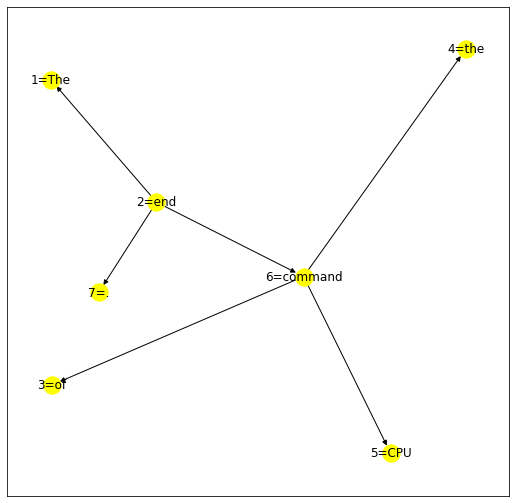

In [233]:
import networkx as nx 
import matplotlib.pyplot as plt

G = nx.DiGraph() 
#nodes_list = [(1,1),(2,2),(3,2)]
nodes_list = [('2=end', '1=The'), ('6=command', '4=the'),('2=end', '6=command'),('2=end', '7=.'),('6=command', '3=of'),('6=command', '5=CPU')]
G.add_edges_from(nodes_list)
  
plt.figure(figsize =(9, 9)) 
nx.draw_networkx(G, with_label = True, node_color ='yellow') 
  
# getting different graph attributes 
print("Total number of nodes: ", int(G.number_of_nodes())) 
print("Total number of edges: ", int(G.number_of_edges())) 
print("List of all nodes: ", list(G.nodes())) 
print("List of all edges: ", list(G.edges())) 
print("In-degree for all nodes: ", dict(G.in_degree())) 
print("Out degree for all nodes: ", dict(G.out_degree)) 
  
print("Total number of self-loops: ", int(G.number_of_selfloops())) 
# print("List of all nodes with self-loops: ", 
#              list(G.nodes_with_selfloops())) 
  
# print("List of all nodes we can go to in a single step from node 2: ", 
#                                                 list(G.successors(2))) 
  
# print("List of all nodes from which we can go to node 2 in a single step: ", 
#                                                     list(G.predecessors(2))) 

#### Other Note